# BackEnd for Vacuum Gauge Explorer
Contains the classes needed to operate the Vacuum Gauge explorer:
* **VGcontext**: Contains information at the level of a fill
    * Fill Number
    * Beam Energy
    * Beam Intensity
    * Bunch Lenghts
    * Probe Catalogue (file containing names of valid probes)
* **VGprobe**: Contains information at the level of a probe e.g. raw readings
    * Probe ID 
    * Time Readings
    * Pressure Readings
    * Processed Readings
* **VGplot**: Contains methods needed to visualize 1 or more probes
    * MultiPlot (given VGcontext)
    * SinglePlot (given VGprobe)
* **VGcontrol**: Contrains the tools for stepping through gauges intelligently and applying analyzers to them 

In [1]:
%run BackEnd_Plotters.ipynb
%run BackEnd_DataProcessing.ipynb
import re
import pytimber
import os
import pandas as pd
import pickle
import copy
from IPython.display import clear_output
db = pytimber.LoggingDB()

Populating the interactive namespace from numpy and matplotlib


In [39]:
class VGprobe(object):
    def __init__(self, gauge_id, fill_no, verbose = False):
        self.verbose = verbose
        self.probe_is_valid = True
        self.gauge_id = gauge_id
        self.fill_no = fill_no
       
        
        file_name = "Probe_{0}_Fill{1}.p".format(gauge_id,str(self.fill_no))
        folder = os.path.join(os.getcwd(),"data","probes",str(self.fill_no),gauge_id) 
        file_path = os.path.join(folder,file_name)
        
        if not os.path.exists(folder):
            os.makedirs(folder)
        
        if os.path.isfile(file_path):
            if verbose: print("Loading existing data for {} in Fill {}".format(gauge_id,fill_no))
            with open(file_path,"rb") as pgd_file:
                pgd = pickle.load(pgd_file)
            # Copy attributes from Processed Gauge Data (pgd) to Probe Object
            self.__dict__.update(pgd.__dict__)
        else:
            if verbose: print("Saving new data for {} in Fill {}".format(gauge_id,fill_no))
            try:
                pgd = processed_gauge_data(gauge_id, fill_no)
                pgd.generate_data()
            except:
                self.probe_is_valid = False
                return
            with open(file_path,"wb") as pgd_file:
                pickle.dump(pgd, pgd_file)
            # Copy attributes from Processed Gauge Data (pgd) to Probe Object
            self.__dict__.update(pgd.__dict__)
                
    def __str__(self):
        s = ">>>{0}Probe {2} in Fill {3}{1}<<<<\n".format(color.BOLD,color.END,self.gauge_id,self.fill_no)
        if not self.probe_is_valid:
            return s + "This Probe is {0}NOT VALID{1}".format(color.RED,color.END)
        else:
            return s + "Number of Readings: {}\n".format(self.pressure_readings.shape[0])

In [40]:
class ContextError(Exception):
    pass

In [41]:
class VGcontext(object):
    def pick_fill_number(self,fillNo=None):
        if fillNo is None:
            try:
                maxFillNo = db.getLHCFillData(None)['fillNumber']
            except:
                maxFillNo = 7494
            print("Valid Fill Numbers: 0 - %d (inclusive)" % (maxFillNo))
            fillNo = input("Please select a fill number >>>")
            while(True):
                try:
                    fillNo = int(fillNo)
                    if(fillNo < 0 or fillNo > maxFillNo):
                        print("Please enter a fill number in the correct range")
                        input("Select a fill number >>>")
                        continue
                    break
                except:
                    print("Please enter a valid integer")
                    input("Select a fill number >>>")
        return fillNo
        
    def __init__(self, fillNo=None, verbose = False):
        self.verbose = verbose
        self.fillNo = fillNo if fillNo is not None else self.pick_fill_number()
        self.data_is_valid = True

        fill = db.getLHCFillData(self.fillNo)
        if fill is None:
            self.data_is_valid = False
            #"Could not retrieve fill data for fill {} through PyTimber".format(self.fillNo)
        self.t1 = fill['startTime']
        self.t2 = fill['endTime']
        date1 = datetime.datetime.fromtimestamp(self.t1)
        date2 = datetime.datetime.fromtimestamp(self.t2)
        timeBetween = date2 - date1
        if timeBetween.seconds<(60*60*5):
            self.data_is_valid = False
            self.msg = "{} is too short at {} to be loaded".format(self.fillNo,timeBetween)

        self.beamNumber=1
        beamEnergyVariable='LHC.BOFSU:OFSU_ENERGY'
        beamEnergy=db.get(beamEnergyVariable, self.t1, self.t2)
        if not all(beamEnergy): #True == Non-zeros present
            self.data_is_valid = False
            self.msg = "Beam Energy in Fill {} is INCOMPLETE".format(self.fillNo)
        self.beamEnergy = beamEnergy[beamEnergyVariable]

        beamIntensityVariable= 'LHC.BCTFR.A6R4.B'+str(self.beamNumber)+':BEAM_INTENSITY'
        beamIntensity=db.get(beamIntensityVariable, self.t1, self.t2)
        if not all(beamIntensity): #True == Non-zeros present4
            self.data_is_valid = False
            self.msg = "Beam Intensity in Fill {} is INCOMPLETE".format(self.fillNo)
        self.beamIntensity = beamIntensity[beamIntensityVariable]

        beamBunchVariable='LHC.BQM.B'+str(self.beamNumber)+':BUNCH_LENGTH_MEAN'
        beamBunchLengths=db.get(beamBunchVariable, self.t1, self.t2)
        if not all(beamBunchLengths): #True == Non-zeros present
            self.data_is_valid = False
            self.msg = "Bunch Lengths in Fill {} are INCOMPLETE".format(self.fillNo)
        self.beamBunchLengths = beamBunchLengths[beamBunchVariable]
        
        self.folder = os.path.join(os.getcwd(),"data","contexts",str(self.fillNo))
        if not os.path.exists(self.folder):
            os.makedirs(self.folder)
        self.fileName = "{}_verified_probe_catalogue.csv".format(self.fillNo)
        
        if not os.path.isfile(os.path.join(self.folder,self.fileName)):
            self.probe_catalogue = pd.DataFrame(data=None,index=None,columns=["Probe ID","Status"]) #Empty
        else:
            self.probe_catalogue = pd.read_csv(os.path.join(self.folder,self.fileName))
            
    def save_probe_catalogue(self):
        self.probe_catalogue.to_csv(os.path.join(self.folder,self.fileName))


In [56]:
class VGplot(object):
    
    def __init__(self,list_of_probes,figsize=(12,9),probe_plot_limit=6):
        self.probes = list_of_probes
        
        figures, axes = {},{}
        fig_count = 0
        figures["fig{}".format(fig_count)],\
        axes["axes{}".format(fig_count)] = plt.subplots(1,
                                                        sharex=True,
                                                        figsize=figsize)
        cols = cm.rainbow(np.linspace(0,1,probe_plot_limit))
        count = 0
        for probe in self.probes:
            plt.plot(probe.time_smooth,probe.pressure_smooth,color=cols[count],label=probe.gauge_id)
            count += 1
            
            if count == probe_plot_limit:
                axes["axes{}".format(fig_count)].set_xlabel("Norm. Time")
                axes["axes{}".format(fig_count)].set_ylabel("Norm. Pressure")
                figures["fig{}".format(fig_count)].legend(loc=8, ncol = 3)
                figures["fig{}".format(fig_count)].subplots_adjust(bottom=0.10+0.05*math.ceil(probe_plot_limit/3))  
                figures["fig{}".format(fig_count)].canvas.draw()
                fig_count+=1
                
                figures["fig{}".format(fig_count)],\
                axes["axes{}".format(fig_count)] = plt.subplots(1,
                                                        sharex=True,
                                                        figsize=figsize)
                count = 0
                
        axes["axes{}".format(fig_count)].set_xlabel("Norm. Time")
        axes["axes{}".format(fig_count)].set_ylabel("Norm. Pressure")
        figures["fig{}".format(fig_count)].legend(loc=8, ncol = 3)

        if len(self.probes)-fig_count * probe_plot_limit < 4:
            figures["fig{}".format(fig_count)].subplots_adjust(bottom=0.15)  
        else:
            figures["fig{}".format(fig_count)].subplots_adjust(bottom=0.2)  
        figures["fig{}".format(fig_count)].canvas.draw()

<IPython.core.display.Javascript object>


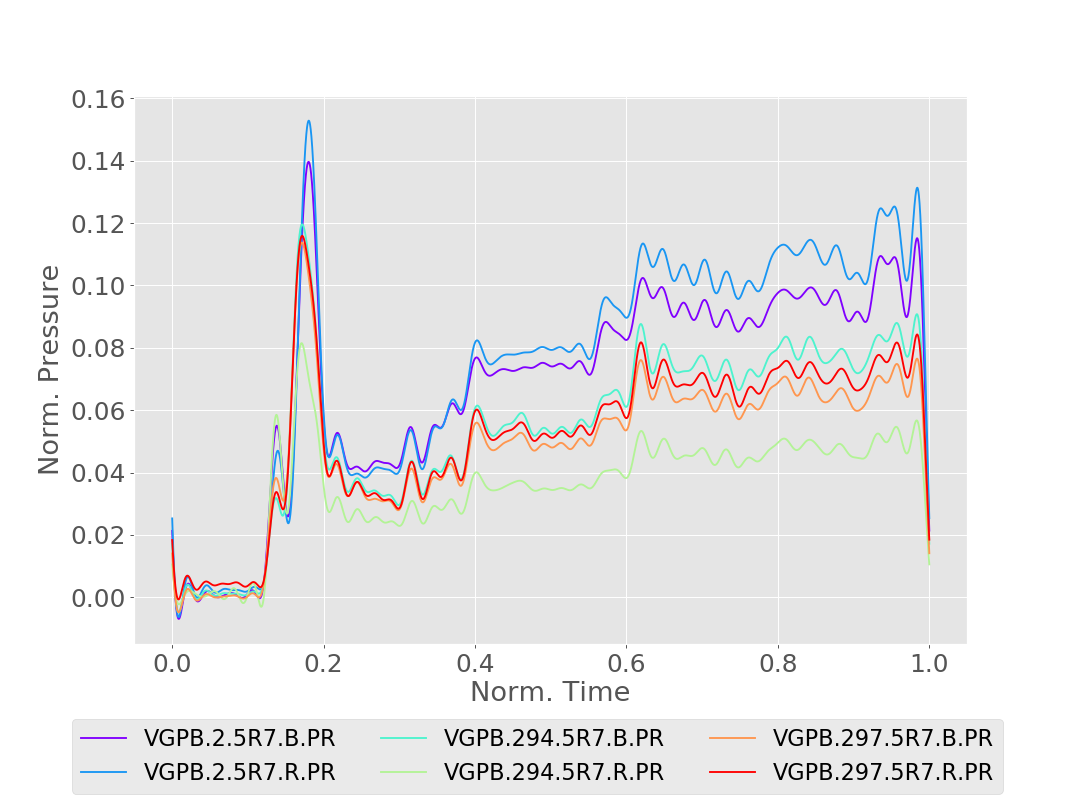

<IPython.core.display.Javascript object>


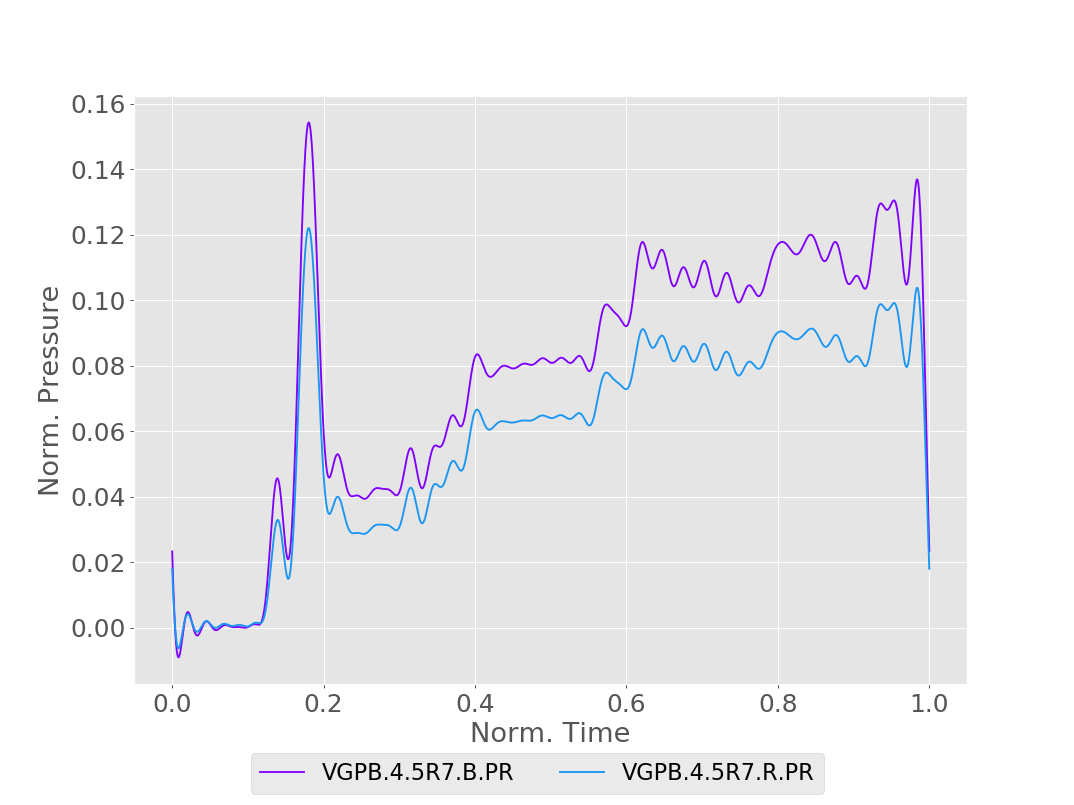

In [57]:
probe_ids = ["VGPB.2.5R7.B.PR","VGPB.2.5R7.R.PR","VGPB.294.5R7.B.PR","VGPB.294.5R7.R.PR","VGPB.297.5R7.B.PR","VGPB.297.5R7.R.PR","VGPB.4.5R7.B.PR","VGPB.4.5R7.R.PR",]
probes = []
for probe_id in probe_ids:
    probe = VGprobe(probe_id,5979)
    if probe.probe_is_valid:
        probes.append(probe)
    
VGplot(probes)

In [38]:
class VGcontrol(object):
    
    @staticmethod
    def generate_location_matrix():
        xx,yy = np.meshgrid(np.arange(1,35),np.arange(1,9))
        location_matrix = np.core.defchararray.add(xx.astype(str),np.full((8,34),"R"))
        location_matrix = pd.DataFrame(np.core.defchararray.add(location_matrix,yy.astype(str)))
        location_matrix.set_index(np.arange(1,9), inplace=True)
        location_matrix.columns = np.arange(1,35)
        return location_matrix
    
    @staticmethod
    def get_gauge_ids_from_selection(selection):
        locations = selection.values.flatten()
        gauge_ids = np.core.defchararray.add("VGPB.%.",locations)
        return np.core.defchararray.add(gauge_ids,".%.PR")
    
    def __init__(self, probe_plot_limit=6,verbose = 0):
        self.verbose = verbose
        self.current_context = VGcontext(fillNo=None)
        try:
            self.maxFillNo = db.getLHCFillData(None)['fillNumber']
        except:
            self.maxFillNo = 7492
            
        # For feedback
        self.current_msg = ""
            
        # For Automatic Stepping
        self.bias = None
        self.teller = 0
        
        # For Fixing Locations
        self.saved_locations, self.save_locations = None, False
        self.location_matrix = VGcontrol.generate_location_matrix()
        
        # For limiting plotting
        self.probe_plot_limit = probe_plot_limit
        
        # For classifier use
        self.try_to_classify=False
        
        self.main()
    
   
    def display_help_and_input(self, msg=None):
        info = """{0}{2}{1}
        Currently at: {3} of {4}
        {0}s:{1} reload current fill
        {0}d:{1} move forward one fill
        {0}a:{1} move backward one fill
        {0}j:{1} jump to a specific fill
        {0}b:{1} step through X fills in specified direction
        {0}f:{1} fix/unfixed location selection
        {0}x:{1} to quit this wizard
        {0}z:{1} analyze using Classifiers""".format(color.BOLD,color.END,msg,self.current_context.fillNo,self.maxFillNo)
        print(info)
        self.resp=input(">>>")
        
    def display_and_select_locations(self):
        print("{}Select which locations to Load from Fill {}{}\nUse format row_start:row_end,col_start:col_end\nExamples: 2 (row 2) or 2,4 (row 2, col 4) or 2:4,3:6 (rows 2-4, cols 3-6)".format(color.BOLD,
        self.current_context.fillNo,color.END))
        display(self.location_matrix)

        while True:
            resp = input(">>>")
            try:
                selection = eval("self.location_matrix.loc[{}]".format(resp))
            except (KeyError, NameError, IndexError, SyntaxError) as e:
                print("{0}Invalid {2}{1}: {3}".format(color.BOLD,color.END,e.__class__.__name__,str(e)))
                continue
            print(">>>{}Selected Locations{}<<<".format(color.BOLD,color.END))

            display(selection)
            if type(selection) is str:
                return pd.DataFrame(data=[selection])
            else:
                return(selection)


    def main(self):
        def move_forward_one_fill(self):
            if self.current_context.fillNo <= self.maxFillNo:
                self.current_context = VGcontext(fillNo=self.current_context.fillNo + 1)
            else:
                print("Reached furthest fill")

        def reload_current_fill(self):
            self.current_context = VGcontext(fillNo=self.current_context.fillNo) # Forces a reload

        def move_backward_one_fill(self):
            if self.current_context.fillNo >= 1:
                self.current_context = VGcontext(fillNo=self.current_context.fillNo - 1)
            else:
                 print("Reached earliest fill")

        def jump_to_specific_fill(self):
            self.current_context = VGcontext(fillNo=None)

        def step_through_X_fills(self): # NOTE: 
            if self.save_locations == False: fix_locations(self) # Enforce fixed locations
            resp = input("Pick a direction, a: back, d: forward")
            bias_options = {"a":-1,"d":1}
            while self.bias is None:
                resp = resp.strip().lower()
                if resp in bias_options:
                    self.bias = bias_options[resp]
                else:
                    resp = input("Pick a direction, a: back, d: forward")
            resp = input("Type the number of fills to go through")

            while self.teller == 0:
                try:
                    resp = int(resp)
                except ValueError:
                    print("Please type a number")
                    resp = input("Type the number of fills to go through")
                    continue
                if (self.bias == 1 and resp < self.maxFillNo-self.current_context.fillNo) or (self.bias == -1 and resp < self.fillNo):
                    self.teller = resp
                    return
                else:
                    print("Chosen number would go out of bounds, try again")
                    resp = input("Type the number of fills to go through")

        def fix_locations(self):
            if self.saved_locations is not None:
                self.saved_locations, self.save_locations = None, False
            else:
                self.save_locations = True

        def apply_classifiers(self):
            self.try_to_classify=True
                        
        commands = {"a":move_backward_one_fill, "s":reload_current_fill, "d":move_forward_one_fill,
                    "j":jump_to_specific_fill, "b":step_through_X_fills, "f":fix_locations,
                    "z":apply_classifiers}
                        
        while True:
            if self.teller == 0:
                self.display_help_and_input(msg=self.current_msg)
            
            if self.bias is not None and self.teller > 0:
                self.current_context = VGcontext(fillNo=self.current_context.fillNo + self.bias)
                if not self.current_context.data_is_valid:
                    continue
                else:
                    if self.verbose: print("Reducing teller to {}".format(self.teller-1))
                    self.teller -= 1
            else:
                #clear_output()
                matches = re.findall("^\s*([a-zA-Z]){1}\s*$",self.resp)
                if len(matches) == 0:
                    self.current_msg = "{} is not a single letter, please try again".format(self.resp)
                    continue
                self.resp = matches[0].lower()
                if self.resp == "x":
                    break # EXIT THE APPLICATION
                elif self.resp in commands:
                    prevFillNo = self.current_context.fillNo
                    commands[self.resp](self)
                    if not self.current_context.data_is_valid:
                        self.bias = self.current_context.fillNo - prevFillNo
                        self.teller += 1
                        if self.verbose: print(self.current_context.msg)
                        continue

            # >>> Select Probe Locations of Interest (or load saved) <<<
            if self.saved_locations is not None:
                selection = self.saved_locations
            else:
                selection = self.display_and_select_locations()
                if self.save_locations and self.saved_locations is None:
                    self.saved_locations = selection
            
            # >>> Create Gauge Objects from Locations <<<
            current_probes = []
            gauge_specs = VGcontrol.get_gauge_ids_from_selection(selection)
            if self.verbose: print("Gauge Specs {} in Fill {}".format(gauge_specs,self.current_context.fillNo))
            for gauge_spec in gauge_specs:
                folder = os.path.join(os.getcwd(),"data","probes",str(self.current_context.fillNo)) 
                if not os.path.exists(folder):
                    os.makedirs(folder)
                matched_probes = db.search(gauge_spec)
                for gauge_id in matched_probes:
                    probe = VGprobe(gauge_id.replace("_","."),self.current_context.fillNo)
                    current_probes.append(probe)
                    if self.verbose: print(probe)
                    self.current_context.probe_catalogue.append({'Probe ID' : gauge_id, 'Status' : probe.probe_is_valid} , ignore_index=True)
            
            # Update Verified Probe Catalogue
            self.current_context.save_probe_catalogue()
            if len(current_probes) > self.probe_plot_limit:
                
            else:
                
                VGplot(current_probes)#,figsize=(10,7),probe_plot_limit=6)
            


Valid Fill Numbers: 0 - 7494 (inclusive)
Please select a fill number >>>5979

        Currently at: 5979 of 7494
        s: reload current fill
        d: move forward one fill
        a: move backward one fill
        j: jump to a specific fill
        b: step through X fills in specified direction
        f: fix/unfixed location selection
        x: to quit this wizard
        z: analyze using Classifiers
>>>s
Select which locations to Load from Fill 5979
Use format row_start:row_end,col_start:col_end
Examples: 2 (row 2) or 2,4 (row 2, col 4) or 2:4,3:6 (rows 2-4, cols 3-6)


,1,2,3,4,5,6,7,8,9,10,...,25,26,27,28,29,30,31,32,33,34
1,1R1,2R1,3R1,4R1,5R1,6R1,7R1,8R1,9R1,10R1,...,25R1,26R1,27R1,28R1,29R1,30R1,31R1,32R1,33R1,34R1
2,1R2,2R2,3R2,4R2,5R2,6R2,7R2,8R2,9R2,10R2,...,25R2,26R2,27R2,28R2,29R2,30R2,31R2,32R2,33R2,34R2
3,1R3,2R3,3R3,4R3,5R3,6R3,7R3,8R3,9R3,10R3,...,25R3,26R3,27R3,28R3,29R3,30R3,31R3,32R3,33R3,34R3
4,1R4,2R4,3R4,4R4,5R4,6R4,7R4,8R4,9R4,10R4,...,25R4,26R4,27R4,28R4,29R4,30R4,31R4,32R4,33R4,34R4
5,1R5,2R5,3R5,4R5,5R5,6R5,7R5,8R5,9R5,10R5,...,25R5,26R5,27R5,28R5,29R5,30R5,31R5,32R5,33R5,34R5
6,1R6,2R6,3R6,4R6,5R6,6R6,7R6,8R6,9R6,10R6,...,25R6,26R6,27R6,28R6,29R6,30R6,31R6,32R6,33R6,34R6
7,1R7,2R7,3R7,4R7,5R7,6R7,7R7,8R7,9R7,10R7,...,25R7,26R7,27R7,28R7,29R7,30R7,31R7,32R7,33R7,34R7
8,1R8,2R8,3R8,4R8,5R8,6R8,7R8,8R8,9R8,10R8,...,25R8,26R8,27R8,28R8,29R8,30R8,31R8,32R8,33R8,34R8


>>>7,5
>>>Selected Locations<<<


'5R7'

Gauge Specs ['VGPB.%.5R7.%.PR'] in Fill 5979
>>>Probe VGPB.2.5R7.B.PR in Fill 5979<<<<
Number of Readings: 77181

>>>Probe VGPB.2.5R7.R.PR in Fill 5979<<<<
Number of Readings: 79893

>>>Probe VGPB.294.5R7.B.PR in Fill 5979<<<<
Number of Readings: 54024

>>>Probe VGPB.294.5R7.R.PR in Fill 5979<<<<
Number of Readings: 77397

>>>Probe VGPB.297.5R7.B.PR in Fill 5979<<<<
Number of Readings: 60366

>>>Probe VGPB.297.5R7.R.PR in Fill 5979<<<<
Number of Readings: 41130

>>>Probe VGPB.4.5R7.B.PR in Fill 5979<<<<
Number of Readings: 84387

>>>Probe VGPB.4.5R7.R.PR in Fill 5979<<<<
Number of Readings: 91377



<IPython.core.display.Javascript object>


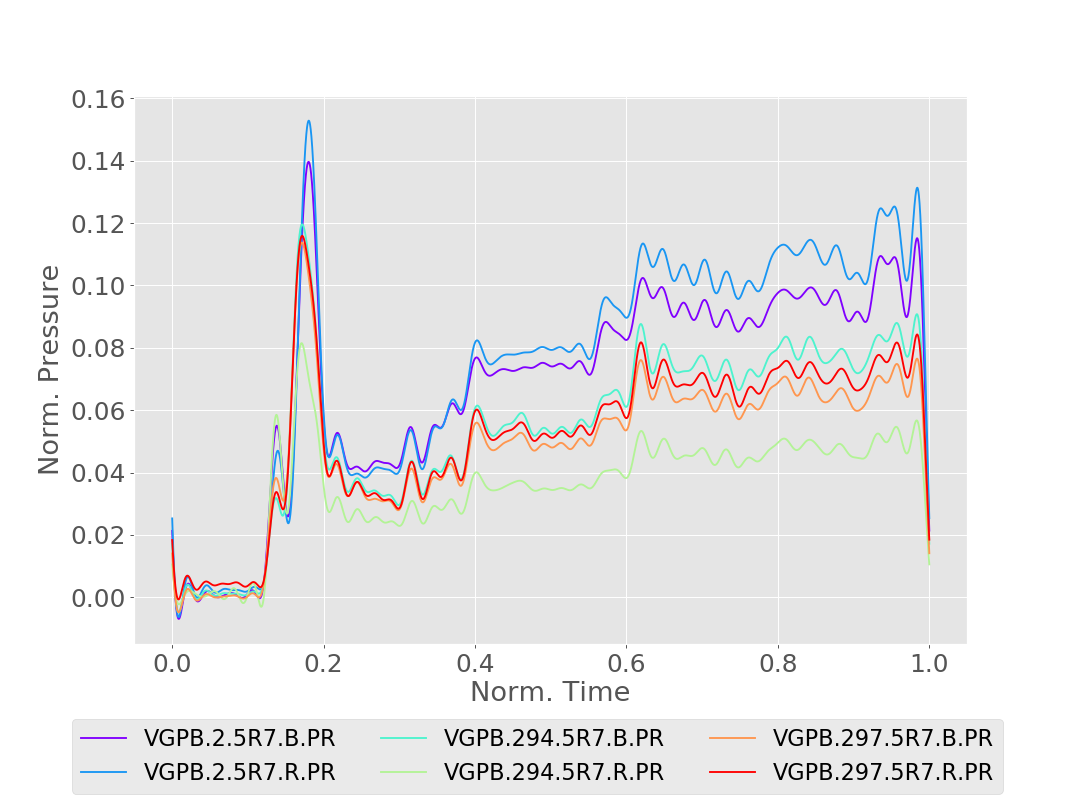

<IPython.core.display.Javascript object>


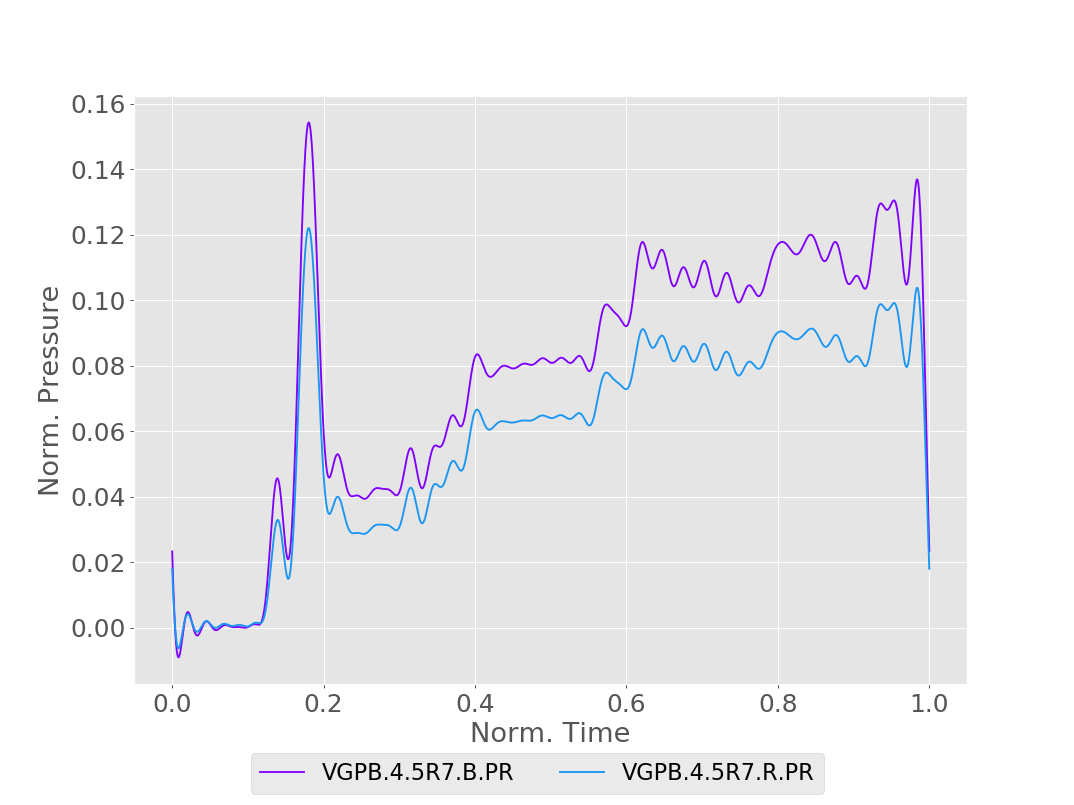


        Currently at: 5979 of 7494
        s: reload current fill
        d: move forward one fill
        a: move backward one fill
        j: jump to a specific fill
        b: step through X fills in specified direction
        f: fix/unfixed location selection
        x: to quit this wizard
        z: analyze using Classifiers
>>>x


In [58]:
VGcontrol(verbose=True)

In [14]:
import numpy as np
import re
import pandas as pd
def generate_location_matrix():
    xx,yy = np.meshgrid(np.arange(1,35),np.arange(1,9))
    location_matrix = np.core.defchararray.add(xx.astype(str),np.full((8,34),"R"))
    location_matrix = pd.DataFrame(np.core.defchararray.add(location_matrix,yy.astype(str)))
    location_matrix.set_index(np.arange(1,9), inplace=True)
    location_matrix.columns = np.arange(1,35)
    return location_matrix

location_matrix = generate_location_matrix()

# Formats
# 0:5 or 6 (twice)
# 2L% %R3 %L%       
resp = input(">>>")
try:
    section = eval("location_matrix.loc[{}]".format(resp))
except KeyError:
    pass
except NameError:
    pass
except IndexingError:
    pass

locations = section.values.flatten()
gauge_ids = np.core.defchararray.add("VGPB.%.",locations)
gauge_ids = np.core.defchararray.add(gauge_ids,".%.PR")
print(gauge_ids)

>>>2
['VGPB.%.1R2.%.PR' 'VGPB.%.2R2.%.PR' 'VGPB.%.3R2.%.PR' 'VGPB.%.4R2.%.PR'
 'VGPB.%.5R2.%.PR' 'VGPB.%.6R2.%.PR' 'VGPB.%.7R2.%.PR' 'VGPB.%.8R2.%.PR'
 'VGPB.%.9R2.%.PR' 'VGPB.%.10R2.%.PR' 'VGPB.%.11R2.%.PR'
 'VGPB.%.12R2.%.PR' 'VGPB.%.13R2.%.PR' 'VGPB.%.14R2.%.PR'
 'VGPB.%.15R2.%.PR' 'VGPB.%.16R2.%.PR' 'VGPB.%.17R2.%.PR'
 'VGPB.%.18R2.%.PR' 'VGPB.%.19R2.%.PR' 'VGPB.%.20R2.%.PR'
 'VGPB.%.21R2.%.PR' 'VGPB.%.22R2.%.PR' 'VGPB.%.23R2.%.PR'
 'VGPB.%.24R2.%.PR' 'VGPB.%.25R2.%.PR' 'VGPB.%.26R2.%.PR'
 'VGPB.%.27R2.%.PR' 'VGPB.%.28R2.%.PR' 'VGPB.%.29R2.%.PR'
 'VGPB.%.30R2.%.PR' 'VGPB.%.31R2.%.PR' 'VGPB.%.32R2.%.PR'
 'VGPB.%.33R2.%.PR' 'VGPB.%.34R2.%.PR']
